In [1]:
######## SETUP DO NOT INCLUDE #########
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
np.random.seed(42)
%matplotlib inline

In [2]:
######## SETUP DO NOT INCLUDE #########
plt.rcParams['figure.figsize'] = (10,7)
plt.style.use('bmh')

In [3]:
######## SETUP DO NOT INCLUDE #########
alpha_reg = 80
beta_reg = 100

alpha_pro = 120
beta_pro = 100

n_games = np.random.randint(low = 50, high=500,size=60000)
ratios = np.append(beta(alpha_reg,beta_reg,size=59500),beta(alpha_pro,beta_pro,size=500))
won = (n_games*ratios).astype(int)
df = pd.DataFrame({'n_games':n_games,'won':won})
df['ratio'] = df.won / df.n_games
df['true'] = ['no'] * 59500 + ['yes'] * 500

# Taming False Discoveries with Rev. Bayes

Todays datascientist have an enormous amount of data at their disposal. But they also face a new problem: With so many features to choose from, how do we prevent making false discoveries?

You might be familiar with the standard approach to deciding if a finding is "significant". We calculate a ["p-value"](https://en.wikipedia.org/wiki/P-value) which describes the probability of recording a cetain event assuming that the null hypothesis is true. If the p-value is low enough, we will reject the null hypothesis in favor of another hypothesis.

A classic example is a doctor giving a group of patients a new drug and another group of patients nothing. For both groups he records the well being of patients to test the null hypothesis that the drug has no effect. If the difference in well being is large enough, and thus the probability of this difference assuming the drug does nothing is very small, say below 5%, we reject the null hypothesis. By rejecting the hypothesis that the drug has no effect, we conclude that the drug has an effect.

p-values lend themselves to false discoveries. Assuming that there is no effect, running 100 independent p-value tests will yield 5 positive outcomes on average. Being misled 5 times is manageble, but if we run millions of hypothesis tests, the situation quickly becomes unbearable.

We need a method that allows us to control the amount of false positives we find. It should scale with the number of hypothesis we run and allow us to be confident about our findings as a whole.

## The problem

You work at a big datascience company which is in the business of predicting the outcome of football games. You and your collegues collect data on players, stadiums, referees, and so on and then build models. Those models in turn inform betting strategies. Over time, you and your collegues have developed 60,000 strategies. Your task is to find strategies whose true winning ratio is above 50%.

Below you see the data: `n_games` describes the number of bets taken with a strategy. `won` describe how often the strategy won and `ratio` is the share of games won. Because this is synthetic data, we know if a strategy's true ratio is above 50%. In real life, you would have no access to the `true` value, but it will be helpful later.

In [4]:
df.head()

,n_games,won,ratio,true
0,152,72,0.473684,no
1,485,259,0.534021,no
2,398,181,0.454774,no
3,320,121,0.378125,no
4,156,74,0.474359,no


The plot below shows the distribution of win-ratios of all strategies. As you can see, there are quite a few strategies with a win-ratio over 0.5.

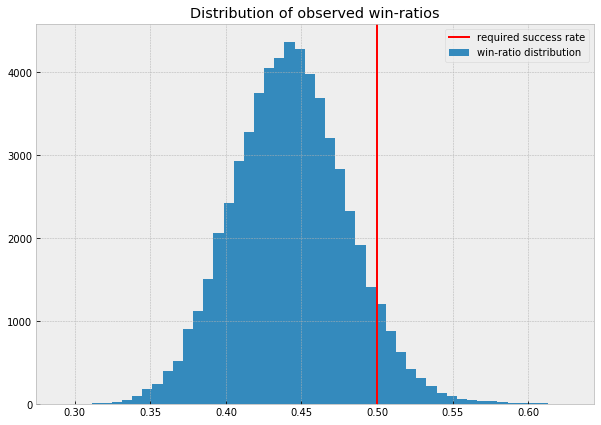

In [5]:
df.ratio.hist(bins=50, label = 'win-ratio distribution')
plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Distribution of observed win-ratios');

The problem is that most of the strategies with high win ratios will be there only by chance. We know that most strategies do not have a win-ratio over 0.5. It is clearly evident in our data. We need to find a way to incorporate this indirect evidence into our result. Good thing that a certain reverend Bayes thought about this exact problem in the 18th century.

## A Matter of Belief

The concepts introduced in this text broadly belong in the area of [Bayesian Statistics](https://en.wikipedia.org/wiki/Bayesian_statistics). The key concept is that we are not as only interested in the distribution of data, but also in the distribution about beliefs about true, unobserved values. The true win-ratio of each strategy is _unobserved_. But we can form an estimate of what the true win-ratio might be. Because we are not 100% sure about our estimate, we think that multiple true values could be true, but do not assign all of them the same probability of being true.

In our daily lives, we do this intuitively. If I asked you what the weather in the Sahara will be tomorrow, you would say: "Probably sunnshine, it hardly ever rains there".

The belief we have before we have seen any data is called the _prior_ belief (prior, aka before, to seeing data). Your belief about the weather in the Sahara was formed without any information about what it is like in the Sahara right now. 

Once we observe data, we can update our beliefs. If I told you that huge rain clouds have sighted over the Sahara and that metrologists are excited for an event of the decade, your answer about the weather would change. You might say "Perhaps it rains, perhaps not. 50/50". This new and updated belief is called the _posterior_ belief (posterior, aka after, to seeing data. Fancy old english).

Mathematically, [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) formulates an update rule, so we can not only intuitively update our beliefs, but also quantitatively. For this we need data and, crucially, a prior.

## Empirical Bayes
Back to our betting strategies, what should our prior belief about the win-ratio of betting strategies be? In the Sahara example, we had a strong prior based on our knowledge of deserts. In the betting example, we only have data and no prior information.

The key idea behind the [Empricial Bayes method](https://en.wikipedia.org/wiki/Empirical_Bayes_method) is to use all of our data to form our prior and then data from specific strategies to form posterior beliefs about the true win-ratios of the different strategies.

In our case, we assume that our belief about a strategies win-ratio can be expressed using a [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution). This means that we don't think there is one true win-ratio but a distribution of different win ratios. The distribution can be described using two parameters, alpha and beta. We can infer the most likely values to have produced our data using [scipy's beta function]:

In [6]:
alpha_prior, beta_prior, _, _ = ss.beta.fit(df['ratio'], floc=0, fscale=1)

With the alpha and beta priors in hand, we can sample from our prior to see that it matches the data. Below you can see the data in blue and the infered prior distribution in orange.

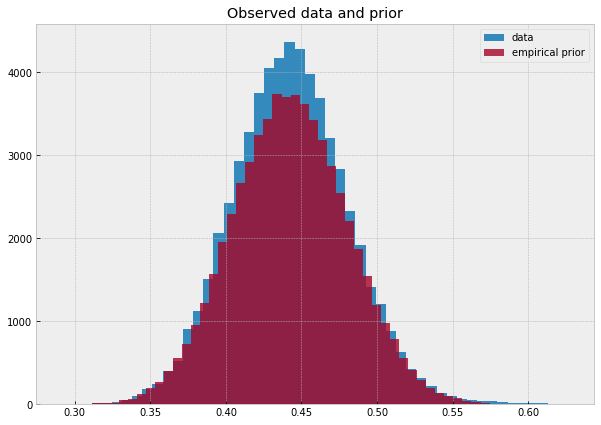

In [7]:
df.ratio.hist(bins=50,label='data')
hist_data = beta(alpha_prior,beta_prior,size=len(df.ratio))
plt.hist(hist_data, histtype='stepfilled',alpha=0.8, bins=50,label='empirical prior')
plt.legend()
plt.title('Observed data and prior');

We can also compute the average win-ratio unde this prior:

In [8]:
prior = alpha_prior / (alpha_prior + beta_prior)
print(f'Expected win ratio under prior: {prior:.4f}')

Expected win ratio under prior: 0.4427


### Can we just estimate a prior like that?
Let's step back here, because what we just did has the flair of some made up stats. Because we lacked a prior that was rooted in knowledge, we just... made one up? That can't be right. But there is an intuitive as well as mathematical logic to this. How did you know that there is little rain in the Sahara? You probably read something written by a geographer who relied on centuries of observations by people and perhaps even artifacts that date back millenia. Based on all that data, the geographer formed the opinion that there is little rain in the Sahara, and you belived it. How is the process of believing the geographer who collected lots of data different from collecting data ourselves?

There is one potential difference and that is that that the geographer collected data on something related to, but ultimately independent from, the object of our study. The geographer did not collect data on weather it will rain _tomorrow_, but only on the general weather in the Sahara. Equally, if we want to use data from the other strategies to inform decisions about any specific strategy, the win-ratios have to be independent of each other. This is also a key assumption the [mathematical justification](https://projecteuclid.org/euclid.bsmsp/1200501653) makes (the technical term is that the data has to come from _parallel situations_. It also has to be suffciently large).

## Updating Our Beliefs
Now that we invested hard work to form a prior, it is time to use the data about individual strategies to form posteriors. For beta distributions, the update rule is relatively straightforward. The posterior of the alpha parameter equals the number of games won by the strategy plus the prior value of alpha.

In [9]:
df['alpha_posterior'] = df.won + alpha_prior

The beta parameter equals the number of games lost by the strategy plus the beta prior.

In [10]:
df['beta_posterior'] = (df.n_games - df.won) + beta_prior

The chart below shows the prior distribution as infered from the data (blue) and the posterior of one specific strategy (orange).

As you can see, this strategy has most of it's posterior values above the required win-ratio. In other words, most of the true win-ratios we think are possible are above the line.

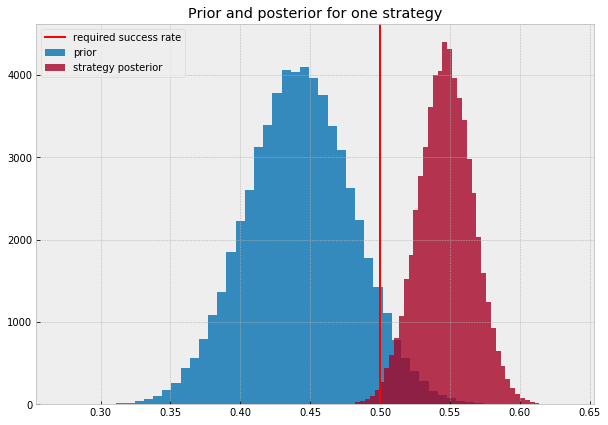

In [11]:
plt.hist(beta(alpha_prior,beta_prior,size=len(df.ratio)),histtype='stepfilled', bins=50, label='prior')
plt.hist(beta(df.alpha_posterior[59901],df.beta_posterior[59901],
              size=len(df.ratio)),histtype='stepfilled', bins=50, alpha=0.8,label='strategy posterior')
plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Prior and posterior for one strategy');

## Shrinkage
Because we take the overall mean win-ratio into account when estimating the true win ratio of each strategy, we "shrink" our estimates towards the grand-mean. Empirical Bayes is a so called "shrinkage" method. As we will see later this is precisely what helps us to reduce false discoveries: We bias our estimates towards finding nothing.

To visualize the shrinkage, let's calculate the mean posterior win ratio for each strategy:

In [12]:
df['eb_ratio'] = df.alpha_posterior / (df.alpha_posterior + df.beta_posterior)

The plot below shows the distribution of win-ratios in the data (blue) and the distribution of estimated true win ratios for all strategies (orange). As you can see, the estimates are all closer to the mean and there are significiantly fewer strategies whose estimated win-ratio is over the requirement (red line).

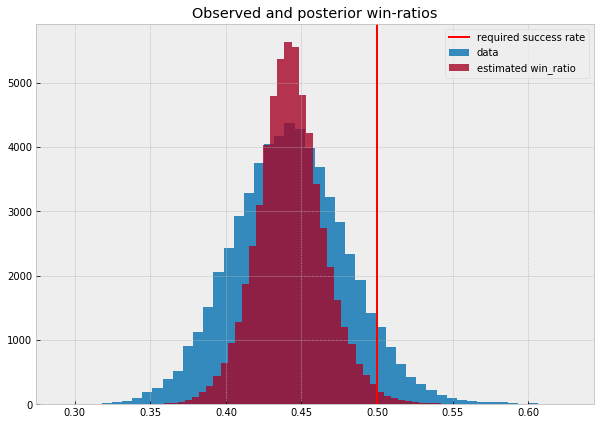

In [13]:
df.ratio.hist(bins=50, label='data');
df.eb_ratio.hist(bins=50,alpha=0.8,label='estimated win_ratio');
plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Observed and posterior win-ratios');

Of course, not all estimates are shrunk by the same amount. We would expect to shrink estimates for which we have more data (speak which we tried on more games) less than strategies for which we have only little data. This is exactly what is happening. Bayes Rule, as applied to shrink the estimates, takes in account the amount of evidence we have for a posterior that might be different from our prior.

The chart below shows the relationship between shrinkage and the amount of data we have. The solid red line is the line at which the observed win ratio is the estimated win ratio. If a point is near the solid red line there is only little shrinkage. The dashed red line is the prior. Green dots are strategies for which we have a lot of data, blue dots are strategies for which we have only little data.

As you can see, strategies for which have little data (blue) are closer to the prior and further away from the observed value. Strategies for which we have a lot of data (green) are shrunk less towards the prior.

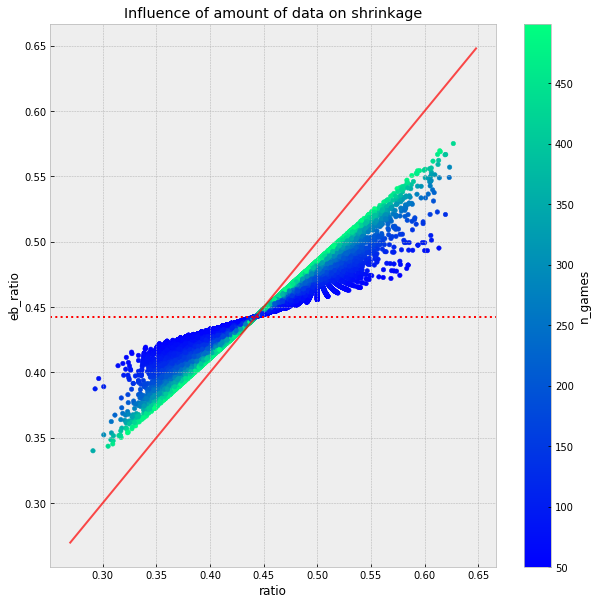

In [14]:
# use of `sharex` is a hack due to a known bug in pandas:
# https://github.com/pandas-dev/pandas/issues/10611
ax = df.plot.scatter(x='ratio', y='eb_ratio', c='n_games',
                            colormap='winter', figsize=(10,10), grid=True,
                            sharex=False)

plt.axhline(prior, color='r', linestyle=':')

# draw a straight line where x = y
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]

plt.plot(lims, lims, 'r-', alpha=.7)
plt.title('Influence of amount of data on shrinkage');

## False Discovery Rates

As we saw earlier, we do not only estimate one true win-ratio for each strategy. We estimate an entire distribution of win-ratios we deem possible. This was a lot of extra work, but it greatly simplifies the question we came here for: "How likely is it that the strategy is a false discovery, and the true win-ratio is below 0.5?"

To answer this, we can ask ourselves: "What share of our posterior belief distribution for our strategy is below 0.5?"

The chart below shows the posterior belief distribution of a strategy. The red line is the critical hurdle of 0.5. The orange area shows the part of the belief distribution that is below the hurdle. Under our belief, the probability that the true win-ratio is less than 0.5 is the orange area.

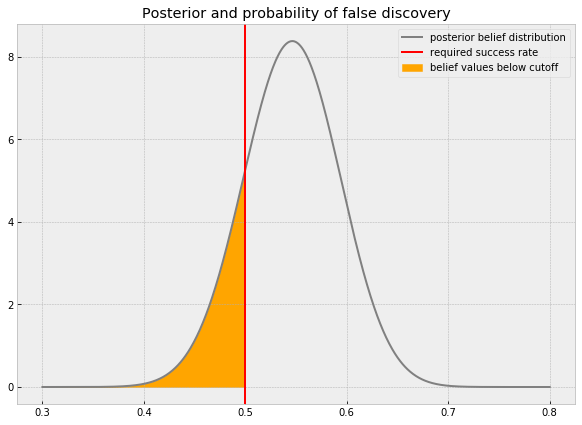

In [15]:
t_values = np.linspace(0.3, 0.8, 1000)
pdf_values = ss.beta.pdf(t_values,60,50)

plt.plot(t_values, pdf_values, color='grey', label='posterior belief distribution')
plt.fill_between(t_values, pdf_values,
                        where=t_values <= 0.5,color='orange',label='belief values below cutoff')

plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Posterior and probability of false discovery');

We can compute the area, and thus the probability that this strategy is a false discovery, with the [cumulative density function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the beta distribution.

In [16]:
print(f'The probability that this strategy is a false discovery is {ss.beta.cdf(0.5,60,50)*100:.3} %')

The probability that this strategy is a false discovery is 16.9 %


This method can be applied to all strategies to find out the likehood that they are a false discovery:

In [17]:
df['FDR'] = ss.beta.cdf(0.5,df.alpha_posterior,df.beta_posterior)

The table below shows the data for the 5 strategies which are least likely to be false discoveries.

In [18]:
df = df.sort_values('FDR').reset_index()
df.head(5)

,index,n_games,won,ratio,true,alpha_posterior,beta_posterior,eb_ratio,FDR
0,59512,434,272,0.626728,yes,346.88018,256.259248,0.575124,0.000108
1,59829,482,296,0.614108,yes,370.88018,280.259248,0.569586,0.000186
2,59581,467,287,0.614561,yes,361.88018,274.259248,0.568869,0.000249
3,59545,464,284,0.612069,yes,358.88018,274.259248,0.566826,0.000375
4,59637,397,246,0.619647,yes,320.88018,245.259248,0.566786,0.000723


## Managing the Overall False Discovery Rate
Now how do we choose which strategies to make bets with? We could simply pick strategies that have a low probability of being a false discovery by themselves. But we can do better. Because of the [linearity of expectation](https://brilliant.org/wiki/linearity-of-expectation/), the expectet rate of false discoveries of multiple strategies is the sum of the individual probabilities of being a false discovery. E.g. if we have ten strategies with a 1% probability of being a false discovery, then the expected share of false discoveries in those ten strategies is 10%.

We can thus choose which share of false discoveries we find acceptable. Let's say, in our betting business we are fine if 5% of our deployed betting strategies do not have a true win-ratio above 0.5. We can then sort the strategies by their individual probability of being a false discoveries and choose those that cumulatively have a false discovery rate of 5%

In [19]:
accepted = df[df.FDR.cumsum() < 0.05]

Since this is synthetic data, we can check how well this worked, and indeed, we find that about 5% of our strategies do not actually have a sufficient win-ratio.

In [20]:
print(f"The actual false discovery rate is {(len(accepted[accepted.true == 'no']) / len(accepted)*100):.2f}%")

The actual false discovery rate is 5.26%


## Epilogue
In this text you have seen the basic building blocks of the empirical bayes framework and how you can use it to manage your false discovery rates.

Empirical bayes belongs to a broader family of [shrinkage](https://en.wikipedia.org/wiki/Shrinkage_(statistics)) methods which are all ways of regularizing. Regularization is a [common](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a) [theme](https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea) in [machine](https://www.quora.com/What-is-regularization-in-machine-learning) [learning](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) so you might have encountered it in the context of ML before. Whenever you run the risk of making a false discovery, be it an overfit set of parameters in a deep learning model or a humble win-ratio, it is useful to bias your findings towards finding nothing. Often, this works with a method strongly related to empirical bayes, such as in [ridge regression](http://statweb.stanford.edu/~ckirby/brad/other/CASI_Chap7_Nov2014.pdf).

As datascience moves into more and more high-stakes applications where a false discovery or an overfit model can have catastrophal consequences, regularization becomes more and more important.


## Further Reading
This text is part of my study notes for [Bradley Efron and Trevor Hastie's "Computer Age Statistical Inference"](https://web.stanford.edu/~hastie/CASI/) which covers this and other topics in much more detail. Efron also wrote a book purely on empirical bayes ["Large Scale Inference"](https://statweb.stanford.edu/~ckirby/brad/LSI/monograph_CUP.pdf). David Robinson has written a more [code driven introduction](http://varianceexplained.org/r/empirical-bayes-book/). If you enjoyed this text, consider buying my book on [ML for finance](https://www.amazon.co.uk/Machine-Learning-Finance-algorithms-financial/dp/1789136369/ref=sr_1_1?ie=UTF8&qid=1547217679&sr=8-1&keywords=machine+learning+for+finance).